In [1]:
%env CUDA_VISIBLE_DEVICES=2
%env XLA_PYTHON_CLIENT_PREALLOCATE=false
%env JAX_ENABLE_X64=True

from datasets import SinusoidDataset
from models import MLPCNF

env: CUDA_VISIBLE_DEVICES=2
env: XLA_PYTHON_CLIENT_PREALLOCATE=false
env: JAX_ENABLE_X64=True


In [ ]:
dataset = SinusoidDataset()
x_shapes, y_shape = dataset.xy_shapes()
model = MLPCNF(x_dim=len(x_shapes), y_dim=y_shape[-1], dim=64, depth=4)
model, losses = model.fit(dataset, batch_size=4*1024, epochs=100, learning_rate=3e-4)

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [01:17<05:05, 38.13s/it, loss=0.19140586748921118]

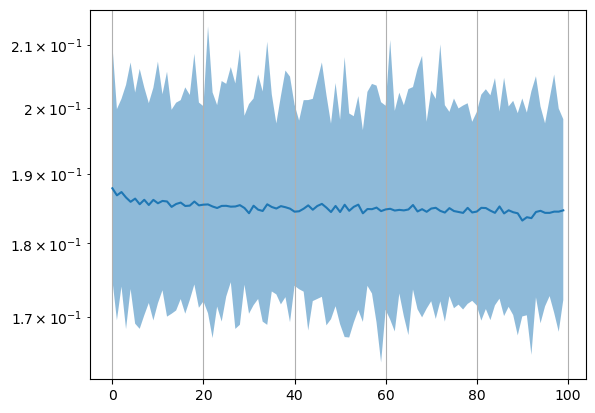

In [ ]:
import matplotlib.pyplot as plt
import treescope
plt.semilogy(losses.mean(axis=-1))
plt.fill_between(range(len(losses)), losses.min(axis=-1), losses.max(axis=-1), alpha=0.5)
plt.grid()
plt.show()
treescope.display(model)

In [ ]:
from tqdm.auto import tqdm
import corner
import numpy as np

import jax
import jax.numpy as jnp
import jax.random as jr
import blackjax

NSAMPLES = 4*1024

@jax.jit
def prior(rng):
    x = jax.vmap(dataset.sample_params)(jr.split(rng, NSAMPLES))
    return jnp.concatenate(x, axis=-1)


@jax.jit
def cnf_sample(rng, y):
    @jax.vmap
    def batch_push(x0):
        return model.push(dataset.priors, x0, y, n_steps=64)

    x0 = jax.vmap(dataset.sample_params)(jr.split(rng, NSAMPLES))
    x1, xt = batch_push(x0)
    return jnp.concat(x1, axis=-1)


@jax.jit
def nuts_sample(rng, y, x_true):
    walkers, chain_len = 64, NSAMPLES // 64
    nuts = blackjax.nuts(lambda x: dataset.log_posterior(x, y), 1e-3, jnp.ones(3))

    def scan_fn(state, rng):
        state, info = nuts.step(rng, state)
        return state, state.position

    def get_chain(rng):
        rng, rng_init = jr.split(rng)
        state = nuts.init(x_true, rng_init)
        state, burnt = jax.lax.scan(scan_fn, state, jr.split(rng, chain_len // 10))
        _, chain = jax.lax.scan(scan_fn, state, jr.split(rng, chain_len))
        return chain

    chains = jax.vmap(get_chain)(jr.split(rng, walkers))
    return jnp.concat(chains, axis=-1).reshape(NSAMPLES, -1)

%timeit cnf_sample(jr.key(0), dataset.sample_observation(jr.key(0), dataset.sample_params(jr.key(0))))

175 ms ± 1.17 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


  0%|          | 0/10 [00:00<?, ?it/s]

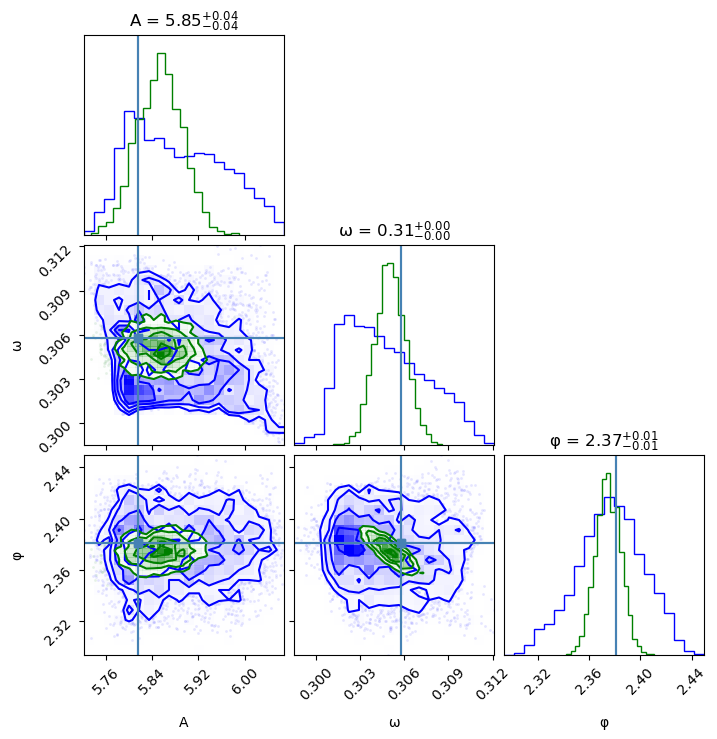

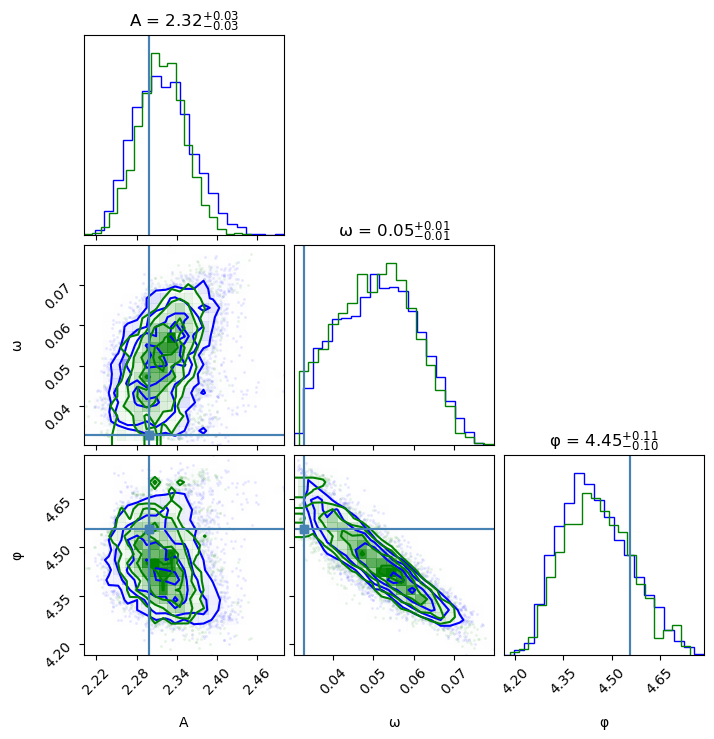

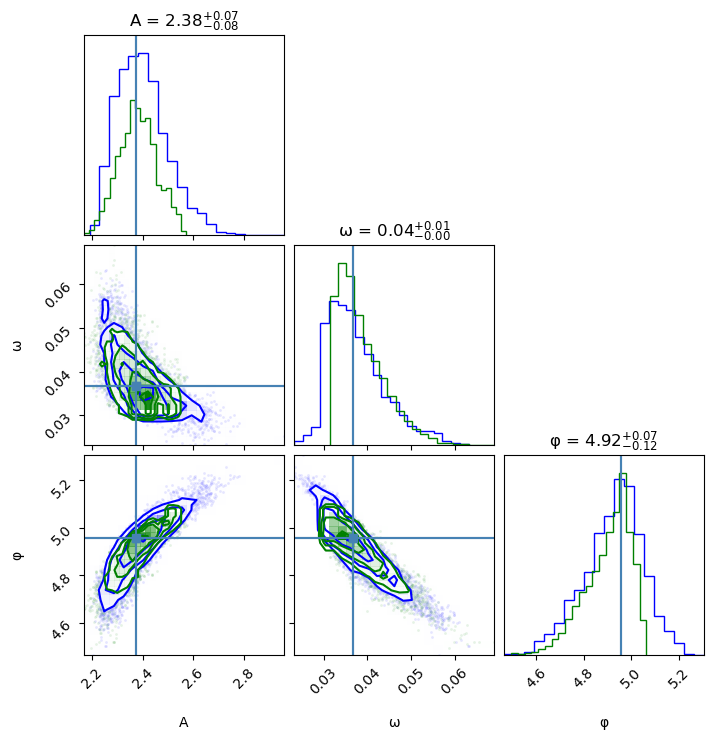

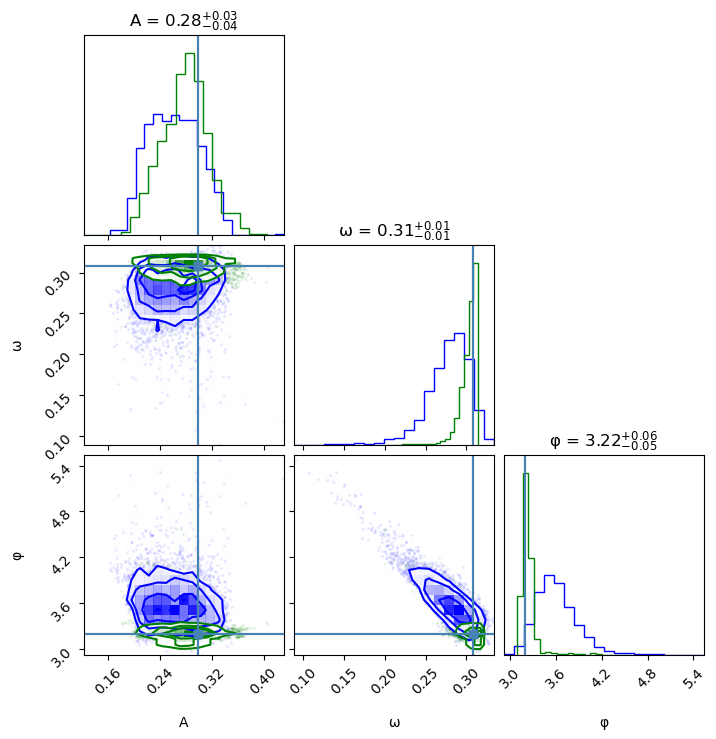

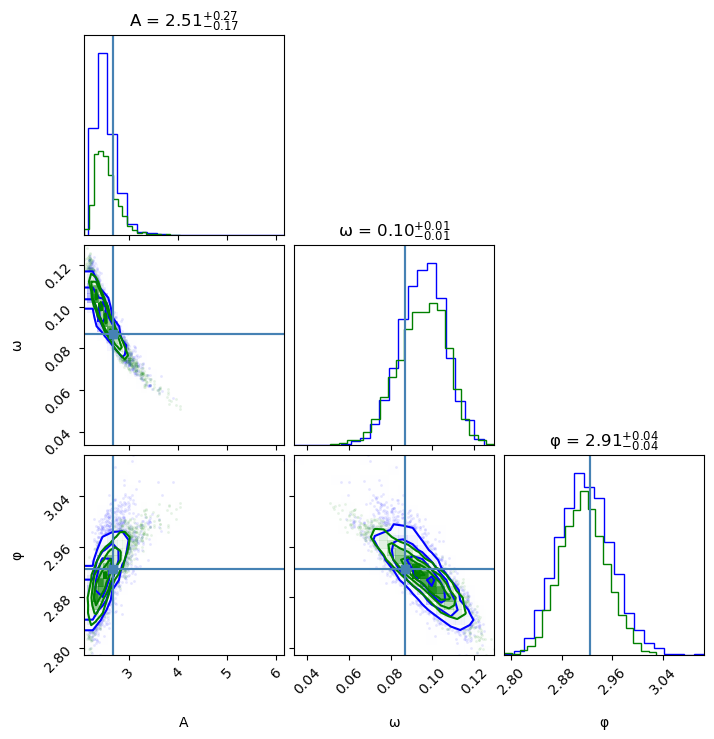

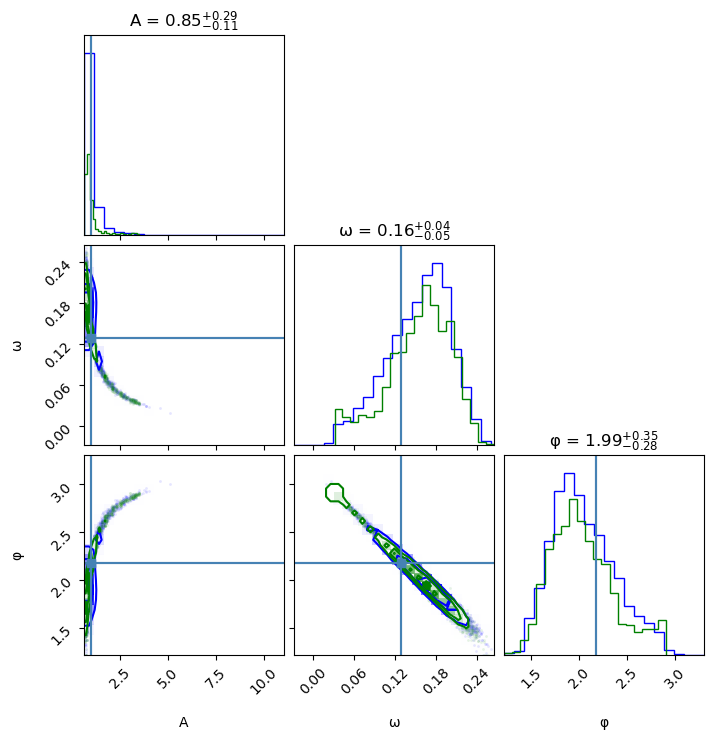

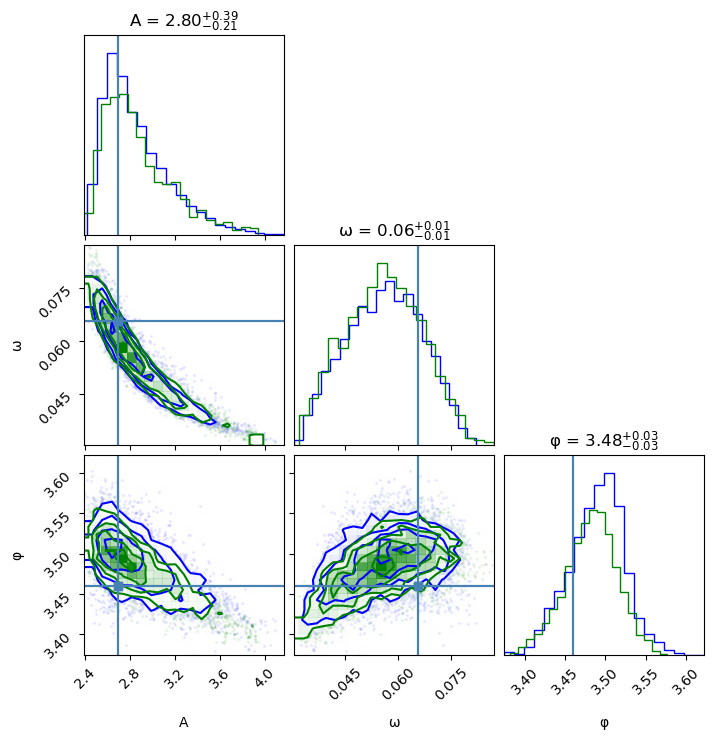

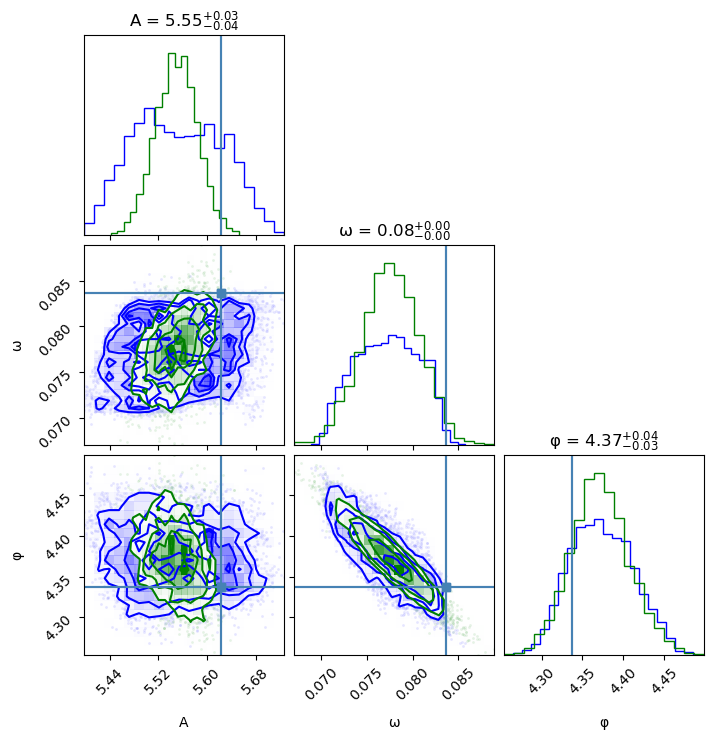

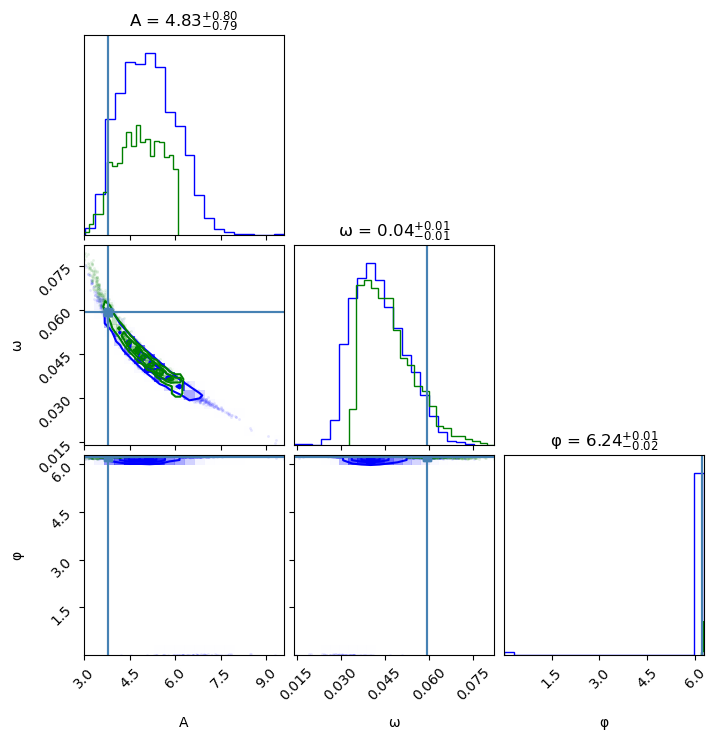

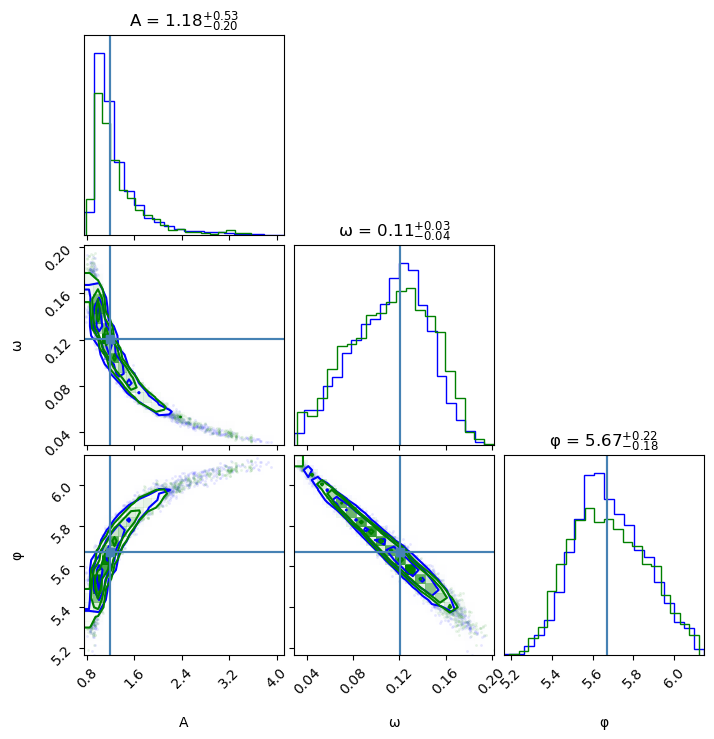

In [13]:
def corner_plot(rng):
    rng_x, rng_y, rng_prior, rng_cnf, rng_mcmc = jr.split(rng, 5)
    x_true = dataset.sample_params(rng_x)
    y = dataset.sample_observation(rng_y, x_true)

    x_prior = np.array(prior(rng_prior))
    x_cnf = np.array(cnf_sample(rng_cnf, y))
    x_mcmc = np.array(nuts_sample(rng_mcmc, y, x_true))

    # plot corner
    corner_kwargs: dict = dict(
        labels=dataset.param_names,
        show_titles=True,
        truths=np.array(jnp.concat(x_true, axis=-1)),
        #axes_scale=["log", "log", "linear"]
    )
    fig = None
    #fig = corner.corner(x_prior, color="black", fig=fig, **corner_kwargs)
    fig = corner.corner(x_cnf, color="blue", fig=fig, **corner_kwargs)
    fig = corner.corner(x_mcmc, color="green", fig=fig, **corner_kwargs)
    plt.show()


for rng in tqdm(jr.split(jr.key(0), 10)):
    corner_plot(rng)